In [1]:
!pip install sentence-transformers
!pip install faiss-cpu
!pip install gdown

In [2]:
!gdown 1q3dpti5aX4LdD3Mq7bZ4rjTeZbQEljiy

Downloading...
From: https://drive.google.com/uc?id=1q3dpti5aX4LdD3Mq7bZ4rjTeZbQEljiy
To: d:\Downloads\AI\ChromaDB\6\image_dataset.zip

  0%|          | 0.00/2.55M [00:00<?, ?B/s]
 21%|██        | 524k/2.55M [00:00<00:01, 1.56MB/s]
 62%|██████▏   | 1.57M/2.55M [00:00<00:00, 2.54MB/s]
 82%|████████▏ | 2.10M/2.55M [00:00<00:00, 2.88MB/s]
100%|██████████| 2.55M/2.55M [00:00<00:00, 3.12MB/s]
100%|██████████| 2.55M/2.55M [00:00<00:00, 2.80MB/s]


In [3]:
import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random

c:\Users\ravin\anaconda3\envs\ai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


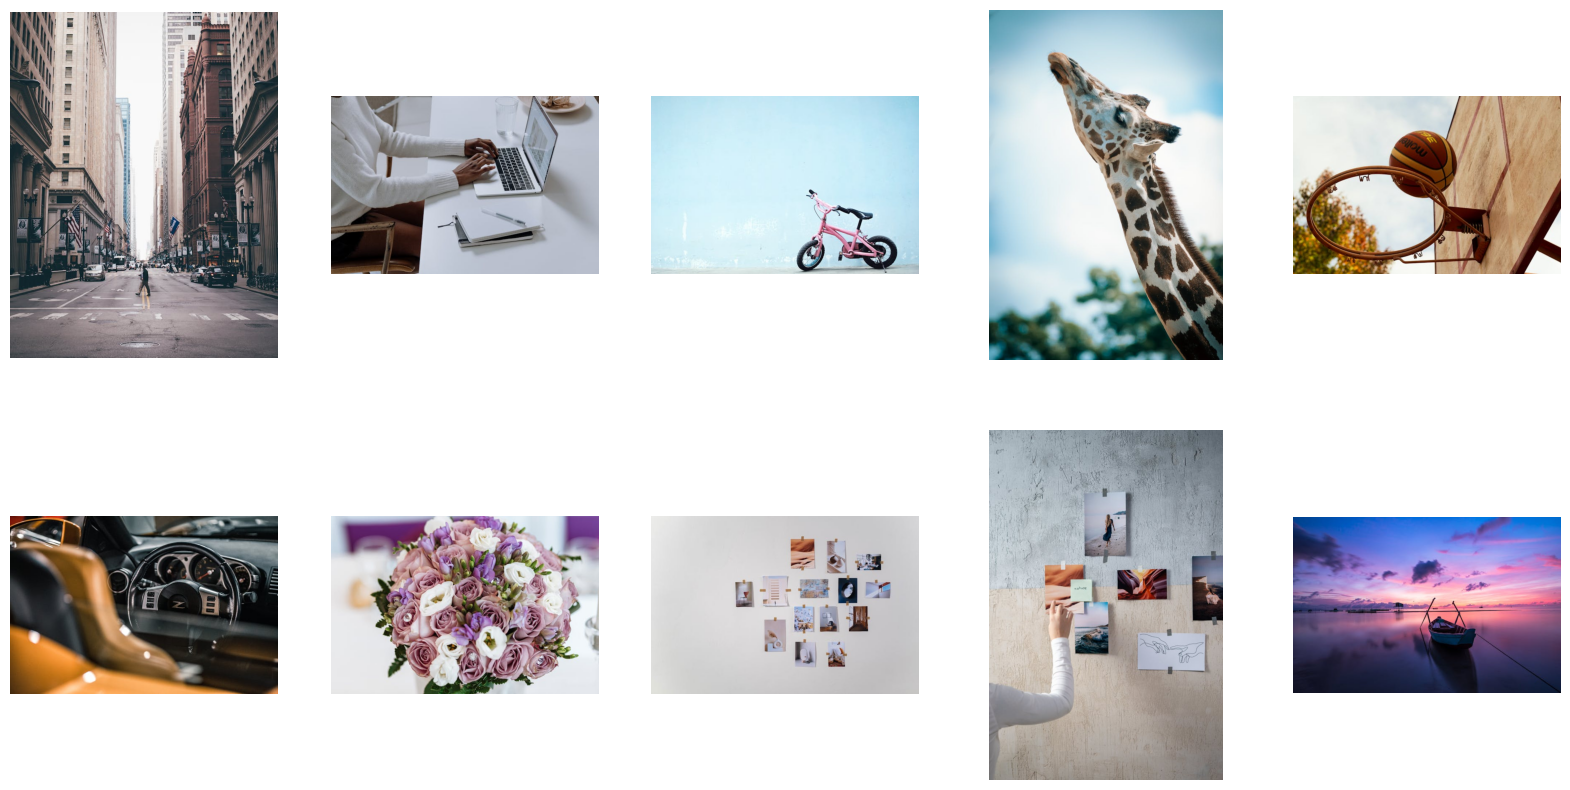

In [4]:
image_folder = 'image_dataset'

# Get a list of all image files in the folder
image_files = glob(os.path.join(image_folder, '*.jpg'))

# Randomly select 10 image files
random.seed(42)
selected_images = random.sample(image_files, 10)

# Display the selected images
plt.figure(figsize=(20, 10))
for i, image_path in enumerate(selected_images):
    img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [5]:
def generate_clip_embeddings(images_path, model):

    image_paths = glob(os.path.join(images_path, '**/*.jpg'), recursive=True)

    embeddings = []
    for img_path in image_paths:
        image = Image.open(img_path)
        embedding = model.encode(image)
        embeddings.append(embedding)

    return embeddings, image_paths



IMAGES_PATH = 'image_dataset'
model = SentenceTransformer('clip-ViT-B-32')
embeddings, image_paths = generate_clip_embeddings(IMAGES_PATH, model)

In [6]:
def create_faiss_index(embeddings, image_paths, output_path):

    dimension = len(embeddings[0])
    index = faiss.IndexFlatIP(dimension)
    index = faiss.IndexIDMap(index)

    vectors = np.array(embeddings).astype(np.float32)

    # Add vectors to the index with IDs
    index.add_with_ids(vectors, np.array(range(len(embeddings))))

    # Save the index
    faiss.write_index(index, output_path)
    print(f"Index created and saved to {output_path}")

    # Save image paths
    with open(output_path + '.paths', 'w') as f:
        for img_path in image_paths:
            f.write(img_path + '\n')

    return index


OUTPUT_INDEX_PATH = "/vector.index"
index = create_faiss_index(embeddings, image_paths, OUTPUT_INDEX_PATH)

Index created and saved to /vector.index


In [7]:
def load_faiss_index(index_path):
    index = faiss.read_index(index_path)
    with open(index_path + '.paths', 'r') as f:
        image_paths = [line.strip() for line in f]
    print(f"Index loaded from {index_path}")
    return index, image_paths

index, image_paths = load_faiss_index(OUTPUT_INDEX_PATH)

Index loaded from /vector.index


In [8]:
def retrieve_similar_images(query, model, index, image_paths, top_k=3):

    if query.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        query = Image.open(query)

    query_features = model.encode(query)
    query_features = query_features.astype(np.float32).reshape(1, -1)

    distances, indices = index.search(query_features, top_k)

    retrieved_images = [image_paths[int(idx)] for idx in indices[0]]

    return query, retrieved_images

In [9]:
def visualize_results(query, retrieved_images):
    plt.figure(figsize=(12, 5))

    # If image query
    if isinstance(query, Image.Image):
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.imshow(query)
        plt.title("Query Image")
        plt.axis('off')
        start_idx = 2

    # If text query
    else:
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
        plt.axis('off')
        start_idx = 2

    # Display images
    for i, img_path in enumerate(retrieved_images):

        plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis('off')

    plt.show()

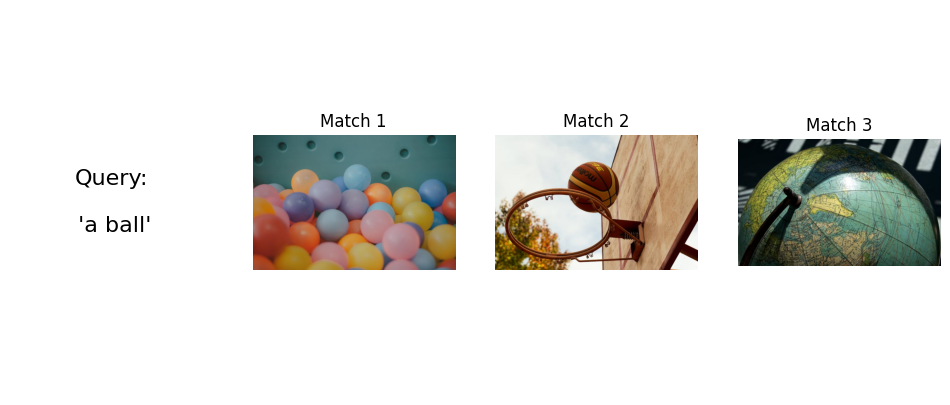

In [10]:
query = 'a ball'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)

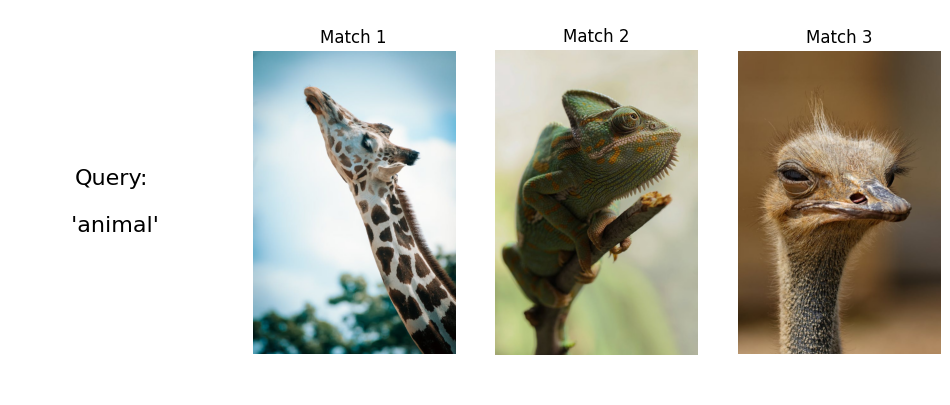

In [11]:
# Example with text query
query = 'animal'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)

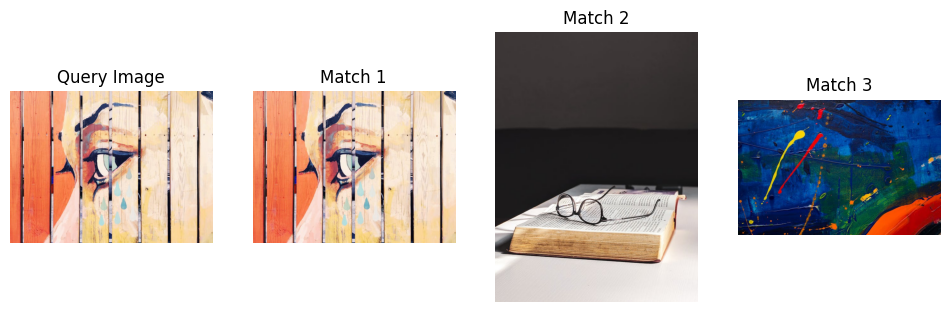

In [12]:
query = 'image_dataset/pexels-w-w-299285-889839.jpg'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)